# ベイジアン固定効果モデル

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [23]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)
df = df[df['island_id'] != 191] # この島は変化率が無限大になるので除外

df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100
df['log_income'] = np.log(df['income'])
df['log_area'] = np.log(df['area_km2'])
df['log_distance'] = np.log(df['distance_m'])
df = df.dropna()

/tmp/ipykernel_38677/37420047.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100


In [24]:
population_change_rate = df['population_change_rate']
bridge = df['dummy_after_bridge_opened']
X = dmatrix('log_income -1', data=df, return_type='dataframe')
islands = dmatrix('C(island_id) -1', data=df, return_type='dataframe')
years = dmatrix('C(year) -1', data=df, return_type='dataframe')

n_x = X.shape[1]
n_islands = islands.shape[1]
n_years = years.shape[1]

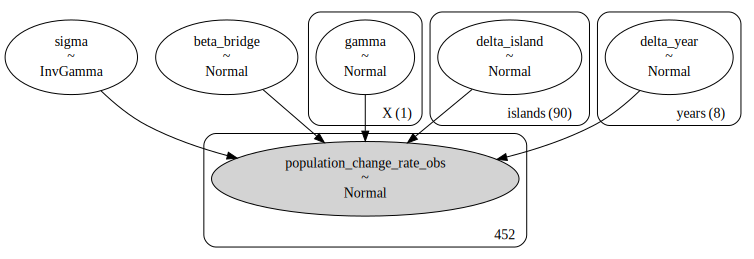

In [25]:
with pm.Model() as model:
    # Priors
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=n_x, dims='X')
    delta_islands = pm.Normal('delta_island', mu=0, sigma=100, shape=n_islands, dims='islands')
    delta_years = pm.Normal('delta_year', mu=0, sigma=100, shape=n_years, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # linear model
    mu = beta_bridge * bridge + pm.math.dot(X, gamma) + pm.math.dot(islands, delta_islands) + pm.math.dot(years, delta_years)

    # Likelihood
    population_change_rate_obs = pm.Normal('population_change_rate_obs', mu=mu, sigma=sigma, observed=population_change_rate)

# モデルの視覚化
pm.model_to_graphviz(model)

In [26]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## アウトプットの保存

In [27]:
az.to_netcdf(idata, 'fixed_effects.nc')

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

## アウトプットのエクスポート

In [8]:
idata = az.from_netcdf('fixed_effects.nc')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_bridge,6.375,5.764,-4.468,17.323,0.123,0.087,2214.0,3804.0,1.00
gamma[0],-0.803,1.024,-2.724,1.118,0.020,0.014,2726.0,5683.0,1.00
delta_island[0],-6.502,11.766,-27.837,16.169,0.615,0.435,366.0,1125.0,1.02
delta_island[1],4.220,12.013,-17.961,27.038,0.617,0.437,378.0,1153.0,1.02
delta_island[2],2.657,11.962,-20.040,24.757,0.619,0.438,374.0,1213.0,1.02
...,...,...,...,...,...,...,...,...,...
delta_year[4],-3.493,13.201,-29.420,20.128,0.619,0.438,455.0,1061.0,1.01
delta_year[5],-8.615,13.254,-33.557,16.150,0.617,0.437,462.0,1066.0,1.01
delta_year[6],-10.242,13.196,-35.156,14.272,0.618,0.437,457.0,1047.0,1.01
delta_year[7],-13.210,13.231,-37.229,12.396,0.619,0.438,457.0,1065.0,1.01


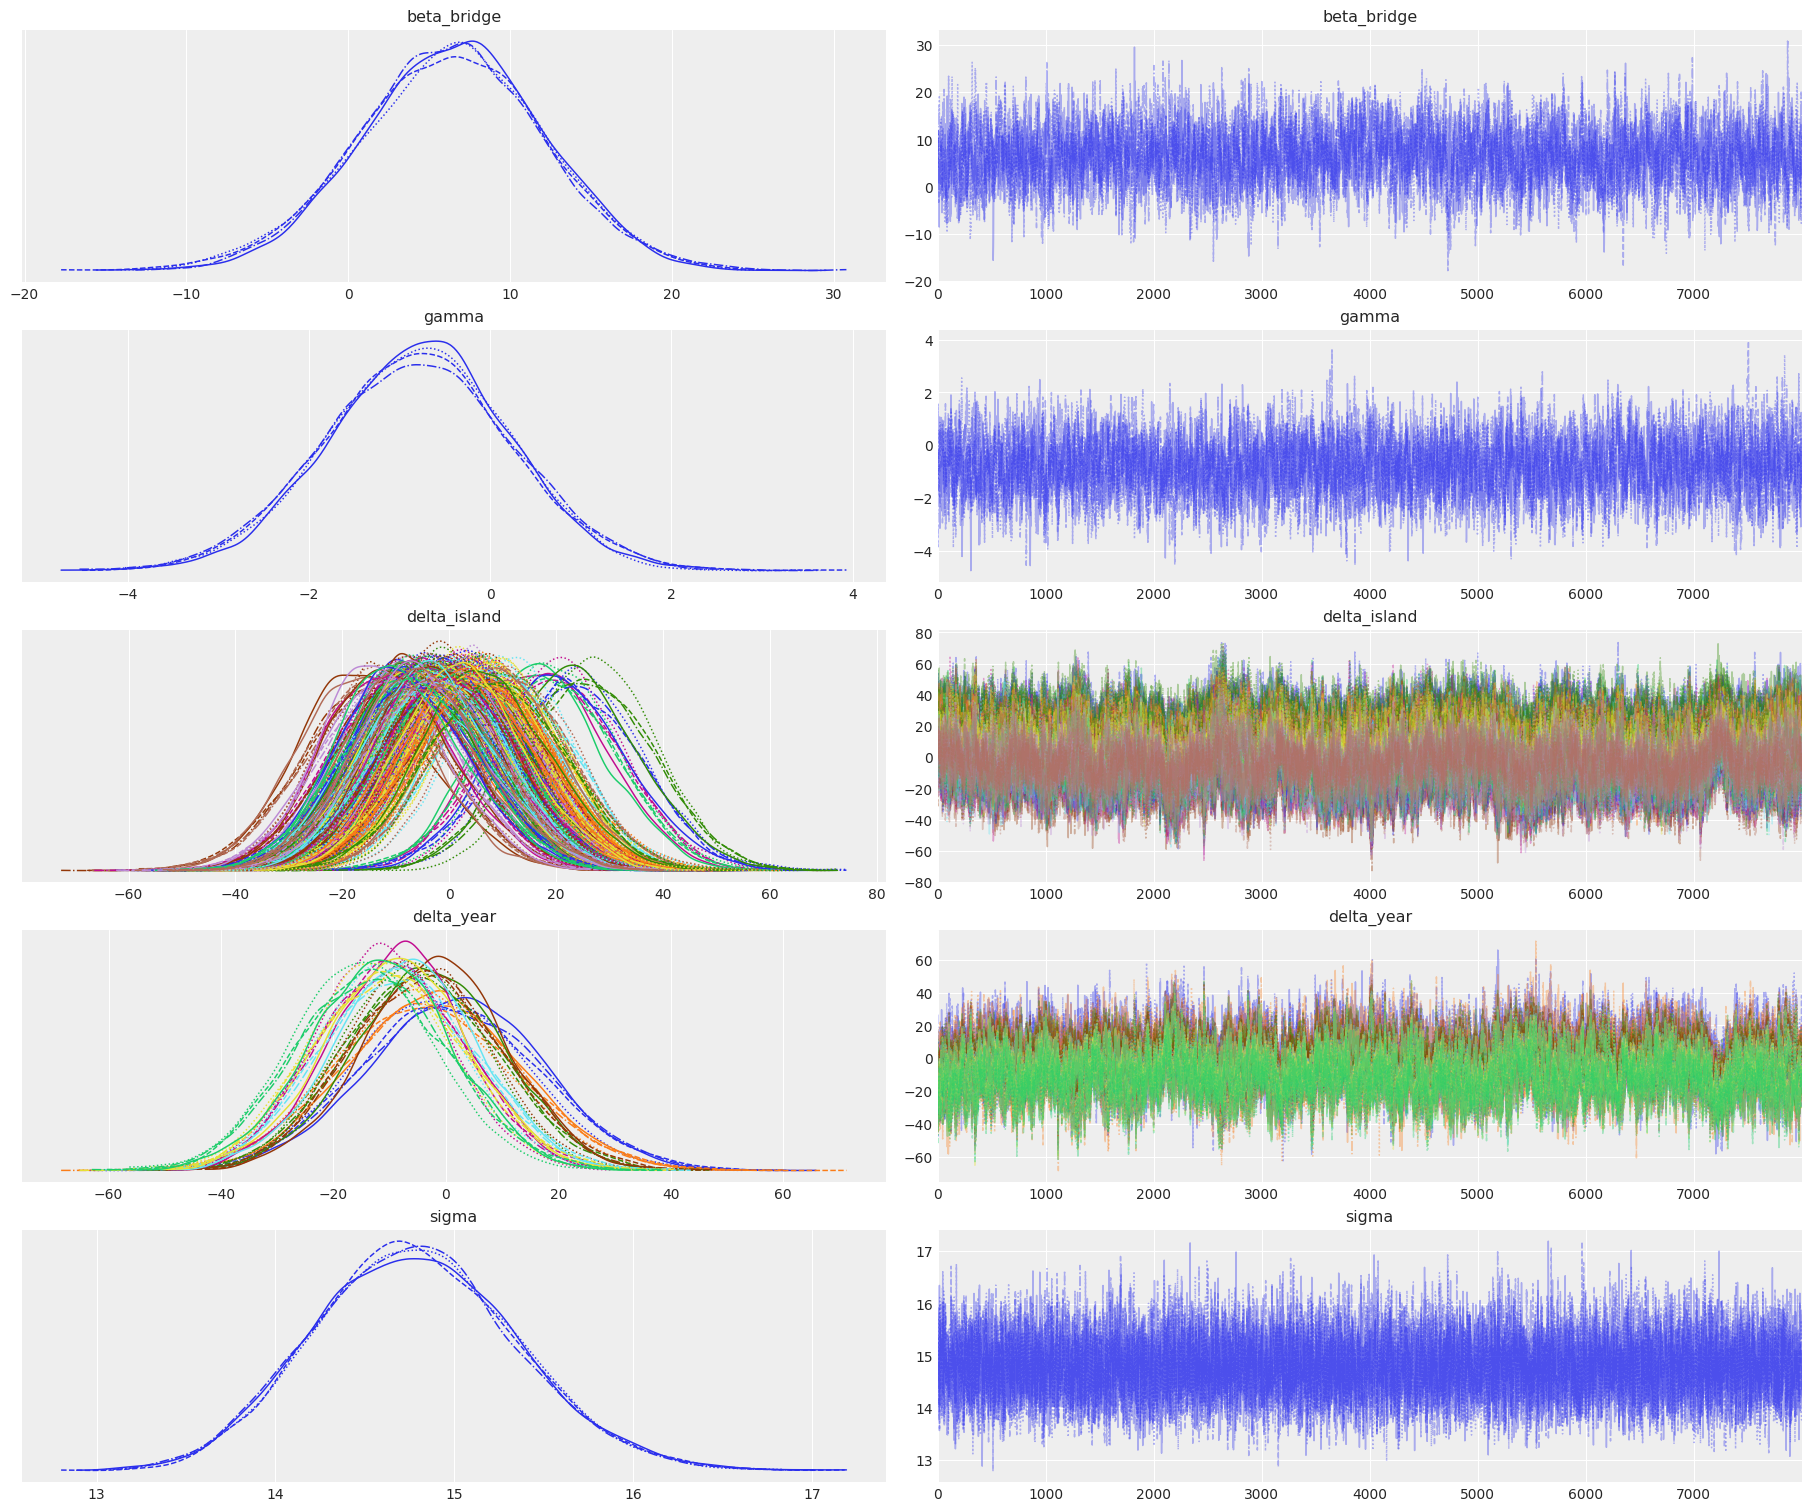

In [28]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)

In [29]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_bridge'] > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['gamma'] > 0)
print(f"Pr(gamma_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_bridge > 0) = 0.8662
Pr(gamma_income > 0) = 0.2140
Pr(sigma > 0) = 1.0000
